This is how much space the figure will take up on letter paper


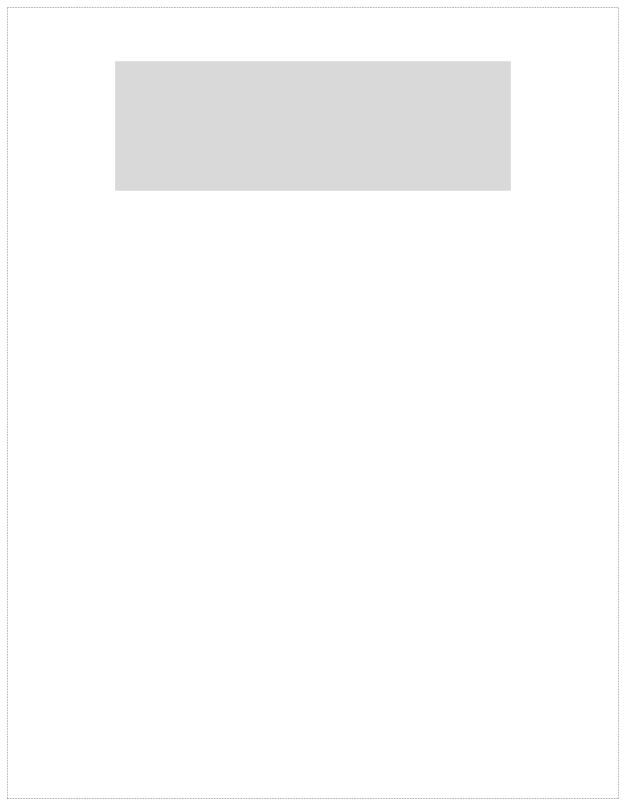

In [1]:
__PRODUCTION__ = 0
__NAME__       = 'efficiency'
__WIDTH__      = 5.5  # NeurIPS 2021 text box width
__HEIGHT__     = 1.8

if __PRODUCTION__:
    from mplmagic import pgf
else:
    from mplmagic import svg

from mplmagic.util import SuperFigure, SuperAxes, size_hint
import matplotlib.pyplot as plt

print('This is how much space the figure will take up on letter paper')
size_hint(__WIDTH__, __HEIGHT__, margin_left=0.5 * (8.5 - __WIDTH__));

In [2]:
import functools
import numpy as np
import colorsys
from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import cdist
import torch
import torch.nn.functional as F
from torch import optim
import networkx as nx
import json
import pickle

from symfac.experimental import RBFExpansionV2

In [8]:
rgn_losses = pickle.loads(open('rgn_losses.pickle', 'rb').read())
gn_losses = pickle.loads(open('gn_losses.pickle', 'rb').read())
er_losses = pickle.loads(open('er_losses.pickle', 'rb').read())
ba_losses = pickle.loads(open('bs_losses.pickle', 'rb').read())

In [9]:
gn_losses

[[0.8862475,
  0.7669685,
  0.6658673,
  0.5782094,
  0.4886611,
  0.423012,
  0.3722493,
  0.3128842,
  0.2674971,
  0.2265098,
  0.194095,
  0.1601433,
  0.1326383,
  0.1054799,
  0.0879271,
  0.070225,
  0.0549454,
  0.0410137,
  0.0331735,
  0.0244024,
  0.0172155,
  0.0127785,
  0.0087629,
  0.0061962,
  0.0036973,
  0.0020948,
  0.0013125,
  0.0007504,
  0.0002799,
  0.0001466,
  4.26e-05,
  6.1e-06,
  1.1e-06,
  0.0],
 [0.9419381,
  0.8859344,
  0.8338748,
  0.7864932,
  0.7406089,
  0.6979499,
  0.659099,
  0.6211723,
  0.5844578,
  0.55076,
  0.5181491,
  0.4868715,
  0.4586237,
  0.4309303,
  0.4039496,
  0.3776128,
  0.3533512,
  0.330026,
  0.3084247,
  0.2876189,
  0.2672495,
  0.2476121,
  0.2287604,
  0.2118642,
  0.196,
  0.1805781,
  0.1658921,
  0.1525258,
  0.139913,
  0.1276961,
  0.1162281,
  0.1054009,
  0.095642,
  0.086845,
  0.0787343,
  0.0706709,
  0.0634952,
  0.0569403,
  0.0507993,
  0.0450045,
  0.0392346,
  0.0343562,
  0.029748,
  0.0256254,
  0.0220613

In [5]:
data = {
    'rectangular-gaussian-noise': {
        'rbf': rgn_losses[0],
        'svd': rgn_losses[1],
    },
    'square-gaussian-noise': {
        'rbf': gn_losses[0],
        'svd': gn_losses[1],
    },
    'erdos-renyi': {
        'svd': er_losses[1],
        'rbf': er_losses[0],
    },
      'barabasi-albert': {
        'svd': ba_losses[1],
        'rbf': ba_losses[0],
    },
}

open('data/efficiency.json', 'w').write(json.dumps(data))

2492

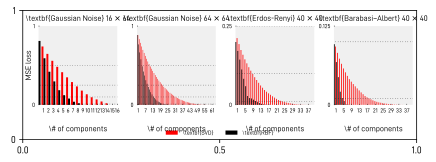

In [6]:
fig = SuperFigure(plt.figure(figsize=(__WIDTH__, __HEIGHT__), dpi=300))
ax_canvas = fig.make_axes(
    left=0, right=1, top=0, bottom=1, zorder=-100,
    style='blank' if __PRODUCTION__ else None
)
ax_canvas.set_xlim([0, 1])
ax_canvas.set_ylim([0, 1])

# draw the axes grid
x0 = 0.04
dx = 0.25
w = 0.20
axs = [
    fig.make_axes(
        left=x0 + dx * i,
        width=w,
        top=0.12,
        width_to_height=1.0,
        style='modern'
    ) for i in range(4)
]


def draw_bars(ax, h, offset, **kwargs):
    ax.bar(np.arange(len(h)) + offset, h, **kwargs)

bar_width = 0.4
bar_style = dict(
    width=bar_width
)
svd_style = dict(
    color='r',
    label=r'\textbf{SVD}'
)
rbf_style = dict(
    color='k',
    label=r'\textbf{RBF}'
)

for i, (ax, (key, case)) in enumerate(zip(axs, data.items())):
    draw_bars(ax, case['svd'], -0.5 * bar_width, **bar_style, **svd_style)
    draw_bars(ax, case['rbf'], 0.5 * bar_width, **bar_style, **rbf_style)
    n = np.max([len(val) for val in case.values()])
    ax.set_xbound(lower=0, upper=n)
    xticks = np.arange(1, n + 1, (n - 9) // 10 + 1)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontsize=6)
    ymax = 2**np.ceil(np.log2(np.max(case['svd'])))
    ax.set_ybound(lower=0, upper=ymax)
    ax.set_ylim([0, ymax])
    yticks = np.linspace(0, ymax, 2)
    ax.set_yticks(yticks)
    ax.set_yticklabels(['%g' % y for y in yticks], fontsize=6)
    ax.tick_params(axis='both', which='both', length=1)
    
    for ref in [0.5, 0.25, 0.1, 0.01]:
        ax.axhline(
            ref,
            color='k',
            lw=0.5,
            ls=(2, (1, 4)),
        )

label_style = dict(
    fontsize=8,
)
for i, ax in enumerate(axs):
    if i == 0:
        ax.set_ylabel(r'MSE loss', labelpad=0, **label_style)
    ax.set_xlabel(r'\# of components', labelpad=3, **label_style)
    
# draw_bars(axs[0], data['rectangular-gaussian-noise']['svd'], -0.5 * bar_width, **bar_style, **svd_style)
# draw_bars(axs[0], data['rectangular-gaussian-noise']['rbf'], 0.5 * bar_width, **bar_style, **rbf_style)

# draw_bars(axs[1], data['square-gaussian-noise']['svd'], -0.5 * bar_width, **bar_style, **svd_style)
# draw_bars(axs[1], data['square-gaussian-noise']['rbf'], 0.5 * bar_width, **bar_style, **rbf_style)

# draw_bars(axs[2], data['erdos-renyi']['svd'], -0.5 * bar_width, **bar_style, **svd_style)
# draw_bars(axs[2], data['erdos-renyi']['rbf'], 0.5 * bar_width, **bar_style, **rbf_style)
    
title_style = dict(
    fontsize=8,
    y=0.975,
    va='bottom'
)
axs[0].set_title(r'\textbf{Gaussian Noise} 16 $\times$ 64', **title_style)
axs[1].set_title(r'\textbf{Gaussian Noise} 64 $\times$ 64', **title_style)
axs[2].set_title(r'\textbf{Erdos-Renyi} 40 $\times$ 40', **title_style)
axs[3].set_title(r'\textbf{Barabasi–Albert} 40 $\times$ 40', **title_style)

ax_canvas.bar([-1], [0], **bar_style, **svd_style)
ax_canvas.bar([-1], [0], **bar_style, **rbf_style)
ax_canvas.legend(
    loc='center',
    bbox_to_anchor=(0.5, 0.05),
    ncol=2,
    frameon=False,
    fontsize=6
)


if __PRODUCTION__:
    fig.savefig(f'pgf/{__NAME__}.pgf', dpi=300)
else:
    fig.savefig(f'svg/{__NAME__}.svg', dpi=300)
plt.show()

In [7]:
!make -f Makefile.figures fig-"$__NAME__".pdf 2>&1 | tail -n 1

make: 'fig-efficiency.pdf' is up to date.


END
---